<a href="https://colab.research.google.com/github/Nisaaaaaputrii/Nisaaaaaputrii.github.io/blob/main/Klasifikasi_Resiko_Penyakit_Jantung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import numpy as np
import pandas as pd

In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("heartDisease").getOrCreate()


In [ ]:
# membaca dataset
file_path = "/content/HeartDisease.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

## Pre-processing Data

In [ ]:
# menampilkan 5 baris
df.show(5)

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 52|  1|  0|     125| 212|  0|      1|    168|    0|    1.0|    2|  2|   3|     0|
| 53|  1|  0|     140| 203|  1|      0|    155|    1|    3.1|    0|  0|   3|     0|
| 70|  1|  0|     145| 174|  0|      1|    125|    1|    2.6|    0|  0|   3|     0|
| 61|  1|  0|     148| 203|  0|      1|    161|    0|    0.0|    2|  1|   3|     0|
| 62|  0|  0|     138| 294|  1|      1|    106|    0|    1.9|    1|  3|   2|     0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
only showing top 5 rows



In [ ]:
# memeriksa tipe data
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)



In [ ]:
# Mengganti nama kolom
df = df.withColumnRenamed("sex", "gender") \
       .withColumnRenamed("target", "HeartDisease")

In [ ]:
from pyspark.sql.functions import count, when, col

# Mengecek missing values per kolom
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+------+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------------+
|age|gender| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|HeartDisease|
+---+------+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------------+
|  0|     0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|           0|
+---+------+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------------+



In [ ]:
# menampilkan summary
df.describe().show()

+-------+-----------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|summary|              age|            gender|                cp|          trestbps|             chol|                fbs|           restecg|           thalach|              exang|           oldpeak|             slope|                ca|              thal|      HeartDisease|
+-------+-----------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|  count|             1025|              1025|              1025|              1025|             1025|               1025|              1025|              1025|            

Matriks Korelasi menggunakan Metode Spearman

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Pilih kolom numerik yang ingin Anda sertakan dalam matriks korelasi
numeric_cols = ['age', 'gender', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'HeartDisease']

# Buat VectorAssembler untuk menggabungkan kolom numerik menjadi satu kolom vektor
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(df).select("features")

# Hitung matriks korelasi menggunakan metode Spearman
correlation_matrix = Correlation.corr(df_vector, "features", method="spearman").head()

# Ekstrak matriks korelasi sebagai Pandas DataFrame untuk visualisasi yang lebih baik
correlation_pandas = correlation_matrix[0].toArray().tolist()
correlation_df = pd.DataFrame(correlation_pandas, columns=numeric_cols, index=numeric_cols)

# Tampilkan matriks korelasi
print(correlation_df)

                   age    gender        cp  trestbps      chol       fbs  \
age           1.000000 -0.105479 -0.092148  0.280189  0.203253  0.110958   
gender       -0.105479  1.000000 -0.053450 -0.071923 -0.152997  0.027200   
cp           -0.092148 -0.053450  1.000000  0.025526 -0.092239  0.073738   
trestbps      0.280189 -0.071923  0.025526  1.000000  0.127010  0.152272   
chol          0.203253 -0.152997 -0.092239  0.127010  1.000000  0.034139   
fbs           0.110958  0.027200  0.073738  0.152272  0.034139  1.000000   
restecg      -0.149732 -0.044169  0.066715 -0.137273 -0.163354 -0.101709   
thalach      -0.382724 -0.047053  0.336116 -0.028880 -0.054794 -0.016292   
exang         0.077594  0.139157 -0.427933  0.043791  0.088895  0.049261   
oldpeak       0.264500  0.090896 -0.195285  0.146722  0.057102  0.032542   
slope        -0.180627 -0.020843  0.169307 -0.081828 -0.026660 -0.048340   
ca            0.339808  0.113834 -0.217002  0.091323  0.114584  0.138197   
thal        

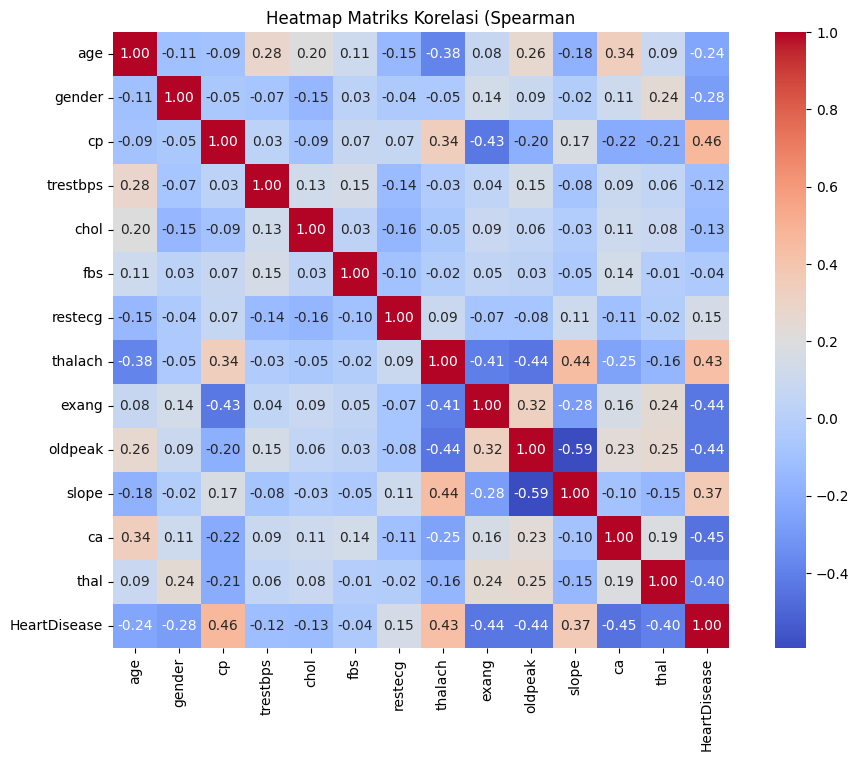

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Buat heatmap menggunakan Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap="coolwarm", square=True) # Pass correlation_df here
plt.title("Heatmap Matriks Korelasi (Spearman")
plt.show()


# Exploratory Data Analysis (EDA)

1. Bar Chart: Distribusi Penderita Penyakit Jantung Berdasarkan Jenis Kelamin

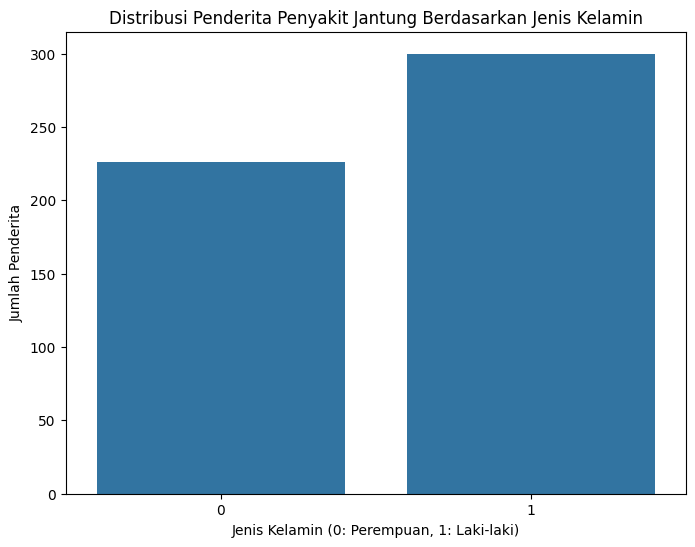

In [ ]:
# Menghitung jumlah penderita penyakit jantung berdasarkan jenis kelamin
gender_counts = df.groupBy("Gender").agg(count(when(col("HeartDisease") == 1, True)).alias("count")).toPandas() # Changed "HeartDisease" to "Heart Disease"

# Membuat bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x="Gender", y="count", data=gender_counts) # Changed "gender" to "Gender"
plt.title("Distribusi Penderita Penyakit Jantung Berdasarkan Jenis Kelamin")
plt.xlabel("Jenis Kelamin (0: Perempuan, 1: Laki-laki)")
plt.ylabel("Jumlah Penderita")
plt.show()

Bar chart ini menunjukkan jumlah penderita penyakit jantung berdasarkan jenis
kelamin. Kita dapat melihat bahwa jumlah penderita penyakit jantung pada laki-laki lebih tinggi dibandingkan perempuan.

2. Pie Chart: Proporsi Penderita Penyakit Jantung

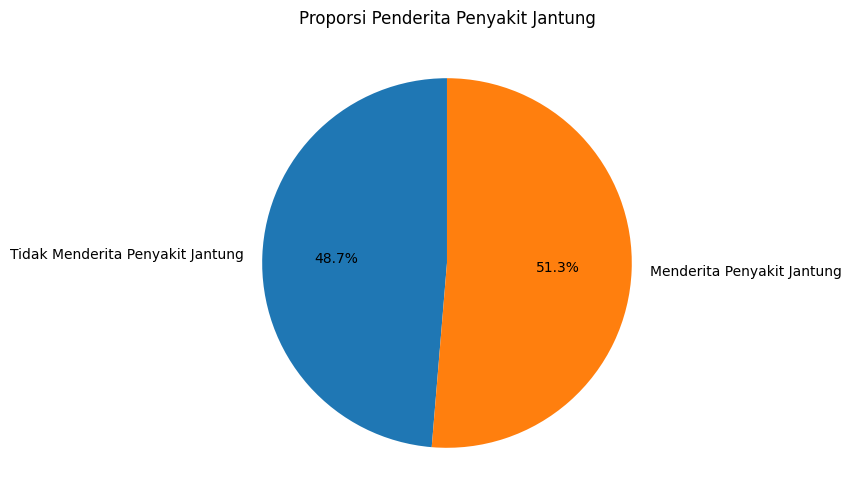

In [ ]:
# Menghitung jumlah total dan proporsi penderita penyakit jantung
total_count = df.count()
heart_disease_count = df.filter(col("HeartDisease") == 1).count()
heart_disease_proportion = heart_disease_count / total_count

# Membuat pie chart
labels = ["Tidak Menderita Penyakit Jantung", "Menderita Penyakit Jantung"]
sizes = [1 - heart_disease_proportion, heart_disease_proportion]
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Proporsi Penderita Penyakit Jantung")
plt.show()

Pie chart ini menunjukkan proporsi penderita penyakit jantung dari total data. Kita dapat melihat bahwa proporsi penderita penyakit jantung sekitar 51.3%.

3. Scatter Plot: Hubungan Antara Usia dan Tekanan Darah dengan Penyakit Jantung

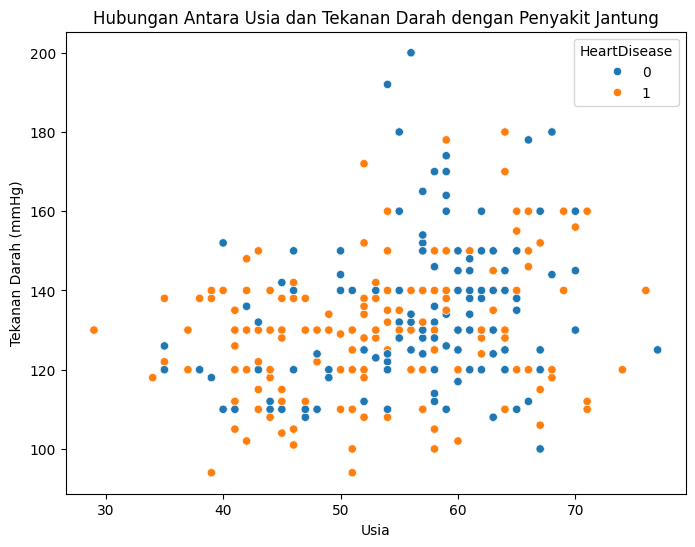

In [ ]:
# Membuat scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x="age", y="trestbps", hue="HeartDisease", data=df.toPandas())
plt.title("Hubungan Antara Usia dan Tekanan Darah dengan Penyakit Jantung")
plt.xlabel("Usia")
plt.ylabel("Tekanan Darah (mmHg)")
plt.show()

Scatter plot ini menunjukkan hubungan antara usia dan tekanan darah dengan penyakit jantung. Kita dapat melihat bahwa terdapat kecenderungan penderita penyakit jantung memiliki usia dan tekanan darah yang lebih tinggi.

4. Box Plot: Distribusi Kolestrol Berdasarkan Penyakit Jantung

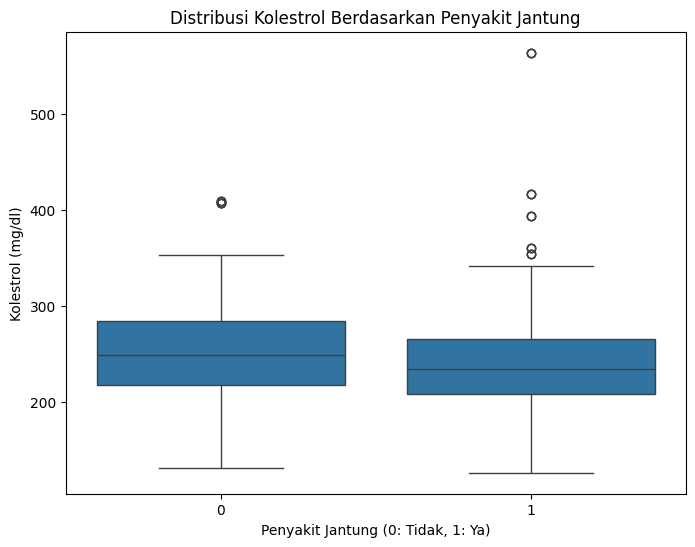

In [ ]:
# Membuat box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x="HeartDisease", y="chol", data=df.toPandas())
plt.title("Distribusi Kolestrol Berdasarkan Penyakit Jantung")
plt.xlabel("Penyakit Jantung (0: Tidak, 1: Ya)")
plt.ylabel("Kolestrol (mg/dl)")
plt.show()

Box plot ini menunjukkan distribusi kolestrol berdasarkan penyakit jantung. Kita dapat melihat bahwa median kolestrol pada penderita penyakit jantung sedikit lebih tinggi dibandingkan dengan yang tidak menderita penyakit jantung.

# model machine learning.

In [ ]:
# Impor pustaka
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

# Memuat dataset
spark = SparkSession.builder.appName("HeartDisease").getOrCreate()
file_path = '/content/HeartDisease.csv'
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Pra-pemrosesan: Menggabungkan fitur
# Fitur yang dipilih menggunakan nama kolom dari DataFrame
fitur_terpilih = ['age', 'cp', 'trestbps', 'chol', 'thalach', 'exang', 'oldpeak', 'slope']
assembler = VectorAssembler(inputCols=fitur_terpilih, outputCol="fitur")
df = assembler.transform(data)

# Mengonversi kolom target ke tipe numerik
df = df.withColumn("Target", df["target"].cast("integer"))

# Membagi data menjadi data latih dan uji
data_latih, data_uji = df.randomSplit([0.8, 0.2], seed=42)

# Mendefinisikan model
model_model = {
    "Random Forest": RandomForestClassifier(featuresCol="fitur", labelCol="Target"),
    "Gradient Boost Tree": GBTClassifier(featuresCol="fitur", labelCol="Target"),
    "Logistik Regresi": LogisticRegression(featuresCol="fitur", labelCol="Target"),
    "Decision Tree": DecisionTreeClassifier(featuresCol="fitur", labelCol="Target")
}

# Mendefinisikan evaluator
evaluator_akurasi = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="f1")
evaluator_presisi = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="weightedRecall")
evaluator_auc = BinaryClassificationEvaluator(labelCol="Target", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Melatih dan mengevaluasi model
hasil = {}
for nama_model, model in model_model.items():
    model_dilatih = model.fit(data_latih)
    prediksi = model_dilatih.transform(data_uji)

    # Menghitung metrik evaluasi
    akurasi = evaluator_akurasi.evaluate(prediksi)
    skor_f1 = evaluator_f1.evaluate(prediksi)
    presisi = evaluator_presisi.evaluate(prediksi)
    recall = evaluator_recall.evaluate(prediksi)
    auc = evaluator_auc.evaluate(prediksi)

    # Menyimpan hasil
    hasil[nama_model] = {
        "Akurasi": akurasi,
        "Skor F1": skor_f1,
        "Presisi": presisi,
        "Recall": recall,
        "AUC": auc
    }

# Menampilkan hasil
print("Perbandingan Performa Model:")
for nama_model, metrik in hasil.items():
    print(f"\n{nama_model}:")
    for nama_metrik, nilai in metrik.items():
        print(f"  {nama_metrik}: {nilai:.4f}")


Perbandingan Performa Model:

Random Forest:
  Akurasi: 0.8639
  Skor F1: 0.8641
  Presisi: 0.8673
  Recall: 0.8639
  AUC: 0.9427

Gradient Boost Tree:
  Akurasi: 0.9822
  Skor F1: 0.9823
  Presisi: 0.9823
  Recall: 0.9822
  AUC: 0.9983

Logistik Regresi:
  Akurasi: 0.7456
  Skor F1: 0.7458
  Presisi: 0.7523
  Recall: 0.7456
  AUC: 0.8308

Decision Tree:
  Akurasi: 0.8521
  Skor F1: 0.8521
  Presisi: 0.8622
  Recall: 0.8521
  AUC: 0.8457


# hyperparameter tuning

In [ ]:
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

# Memuat dataset
spark = SparkSession.builder.appName("HeartDisease").getOrCreate()
file_path = '/content/HeartDisease.csv'
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Pra-pemrosesan
fitur_terpilih = ['age', 'cp', 'trestbps', 'chol', 'thalach', 'exang', 'oldpeak', 'slope']
assembler = VectorAssembler(inputCols=fitur_terpilih, outputCol="fitur")
df = assembler.transform(data).withColumn("Target", data["target"].cast("integer"))

# Membagi data
data_latih, data_uji = df.randomSplit([0.8, 0.2], seed=42)

# Model
model_model = {
    "Random Forest": RandomForestClassifier(featuresCol="fitur", labelCol="Target"),
    "Gradient Boost Tree": GBTClassifier(featuresCol="fitur", labelCol="Target"),
    "Logistic Regression": LogisticRegression(featuresCol="fitur", labelCol="Target"),
    "Decision Tree": DecisionTreeClassifier(featuresCol="fitur", labelCol="Target")
}

# Evaluator
evaluator_auc = BinaryClassificationEvaluator(labelCol="Target", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Evaluasi awal
hasil_awal = {}
for nama_model, model in model_model.items():
    model_dilatih = model.fit(data_latih)
    prediksi = model_dilatih.transform(data_uji)
    auc = evaluator_auc.evaluate(prediksi)
    hasil_awal[nama_model] = auc

# Menampilkan dua model terbaik
model_terbaik = sorted(hasil_awal.items(), key=lambda x: x[1], reverse=True)[:2]
print("\nDua Model dengan Performa Terbaik:")
for model, auc in model_terbaik:
    print(f"{model}: AUC = {auc:.4f}")

# Hyperparameter tuning untuk model terbaik
param_grids = {
    "Random Forest": ParamGridBuilder()
        .addGrid(RandomForestClassifier.maxDepth, [3, 5, 7])
        .addGrid(RandomForestClassifier.numTrees, [10, 20, 50])
        .build(),
    "Gradient Boost Tree": ParamGridBuilder()
        .addGrid(GBTClassifier.maxDepth, [3, 5, 7])
        .addGrid(GBTClassifier.maxIter, [10, 20, 50])
        .build(),
}

# Hasil tuning
hasil_tuning = {}
for nama_model, _ in model_terbaik:
    print(f"\nHyperparameter Tuning untuk {nama_model}...")
    model = model_model[nama_model]
    param_grid = param_grids[nama_model]

    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator_auc,
                              numFolds=5)
    cv_model = crossval.fit(data_latih)

    # Evaluasi model hasil tuning
    prediksi_tuned = cv_model.bestModel.transform(data_uji)
    auc_tuned = evaluator_auc.evaluate(prediksi_tuned)
    hasil_tuning[nama_model] = auc_tuned

# Menampilkan hasil tuning
print("\nHasil Hyperparameter Tuning:")
for model, auc in hasil_tuning.items():
    print(f"{model}: AUC = {auc:.4f}")

# Model terbaik setelah tuning
model_terbaik_final = max(hasil_tuning.items(), key=lambda x: x[1])
print("\nModel Terbaik Setelah Hyperparameter Tuning:")
print(f"{model_terbaik_final[0]} dengan AUC = {model_terbaik_final[1]:.4f}")



Dua Model dengan Performa Terbaik:
Gradient Boost Tree: AUC = 0.9983
Random Forest: AUC = 0.9427

Hyperparameter Tuning untuk Gradient Boost Tree...

Hyperparameter Tuning untuk Random Forest...

Hasil Hyperparameter Tuning:
Gradient Boost Tree: AUC = 0.9983
Random Forest: AUC = 0.9427

Model Terbaik Setelah Hyperparameter Tuning:
Gradient Boost Tree dengan AUC = 0.9983
